## Seq2Seq и его ограничение

Ранее нами была разобрана архитектура Seq2Seq.

Ее идея проста - сначала нейросеть - энкодер, сжимает исходное изображение


<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/seq2seq_1.png" width="550px">


А затем другая нейросеть берет на вход это сжатое представление и на основании него порождает новое предложение (например - перевод)

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/seq2seq_2.png" width="600px">

Использование единственного вектора для предоставления информации может работать только для последовательностей малой длины. Почему? Ибо в этом единственном векторе $c$ можно сжать только конечное количество информации. Потому в какой-то момент нам перестанет хватать "места" в этом векторе.

Нам нужен некий механизм, который будет обходить "бутылочное горлышко" и не сжимать всю информацию в один вектор $c$.

## Attention

Идея проста - не будем делать состояние $c$ фиксированным.

Давайте  Пусть на каждом этапе, при генерации нового слова, наш декодер имеет возможность сформировать новое $c$, на основе всех скрытых состояний $h_i$ енкодера.
Для простоты - пусть он подбирает веса, суммирующиеся в единицу, с которыми сложить эти представления, чтобы получить новое $c$.
Таким образом, в каждый момент времени наш декодер имеет доступ ко всему исходному предложению (представлению каждого слова) и может акцентировать внимание на конкретно нужных в данный момент словах.

Теперь длина пути, который надо преодолеть информации от места ее появления (исходное предложение) до места, где она может пригодиться (новое предложение) - константа, а раньше она была пропорциональна длине исходного предложения.



<img src ="https://miro.medium.com/max/1400/1*B33MU-QFnkTngXklABfJnw.png" width="700">

Единсттвенное остается понять, а как именно будут подбираться веса, с которым будут складываться скрытые состояние енкодера.

Просто сделаем для этого простую нейросеть.


<img src ="https://miro.medium.com/max/1400/1*YM4T-QSJIIPQUlMOO_gnzw.png" width="700">

Давайте посмотрим как фокусировка работает на примере перевода с английского на французский

Как мы знаем, на каждом шаге генерируется набор весов, которые отвечают за фокусировку на том или ином месте входной последовательности.
В английском прилагательные идут перед существительным, в то время как во французском языке наоборот. И наша нейросеть учится этому и обращает внимание на "правильные" слова

<img src ="https://theaisummer.com/static/3bbdf4a6d68559a5d3847a04ebb3370b/8c76f/attention-alignment.png" width="700">

Следующим шагом будет также заметить, что для достаточно длинного предложения наша модель может забыть и то, что она генерирует. Потому мы можем сделать два attention - один на представления исходного предложения, а второе - на представление того, что уже сгенерировано (что еще не сгенерировано - заменяем нулями)


### Проблема attention

Очевидно, у этого подхода есть свои минусы.

Самый важный из них - ваша модель должна уметь предсказывать веса для каждого слова в исходном предложении. И обычные подходы принуждают нас фиксировать размер этого вектора весов.

За счет этого у нас возникло ограничение, от которого мы избавлялись - модель не может принимать (и, если используем attention на то, что сгенерировано, генерировать) предложения больше определенного размера. С другой стороны, ничто не мешает поставить этот максимальный размер достаточно большим, чтобы для бОльшей части предложений это работало.

Почему это не сильный проигрыш в сравненении с LSTM - так оно все равно было ограничено в длине предложения, просто неявно, что даже хуже - лучше иметь модель, которая на длине предложения 45 падает, а не генерирует несвязный текст.

Кроме того, при большом желании, эти проблемы тоже можно обойти




### Image Captioning with RNNs and Attention

В случае, когда мы хотим сгенерировать на основании картинки ее описание.

Можем ввести Attention - просто будем изначальную картинку (лучше, конечно - ее сжатое представление) домножать на вектор весов, указывающих, на какую часть изображения надо обратить внимание.

В каждый момент времени мы акцентируем внимание на конкретных областях картинки

Когда генерим слово птица - смотрим на птицу, люди - смотрим на людей, и тд

<img src ="https://miro.medium.com/max/1400/1*-msb3dvXaCwHRGYi6a261w.png" width="700">

## Словарь

В общем случае, можно представить функционирование словаря следующим образом

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/keyvaluedict.png" width="500px">

In [ ]:
d = {"milk":1, "river": 2, "ocean": 3, "lemon": 4, "watermelon": 5, "sand": 6}


In [ ]:
query = 'milk'
d[query]

1

In [ ]:
d['ocean']

3

Если ключа нет, но в словаре есть похожие ключи (по смыслу) - все равно получим ошибку

In [ ]:
d['water']

KeyError: ignored

Допустим, мы знаем, насколько вода похожа на ключи в словаре

In [ ]:
d = {"milk":1, "river": 2, "ocean": 3, "lemon": 4, "watermelon": 5, "sand": 6}
water_like = {"river": 5, "ocean": 10, "milk": 2, "lemon": 0.2, "watermelon": 1, "sand": 0}

In [ ]:
import numpy as np
similarity = np.array([water_like[k] for k in d.keys()])
values = np.array(list(d.values()))
weights = similarity / similarity.sum()

water_value = np.dot(weights, values)
water_value

2.6263736263736264

То есть если мы умеем вычислять похожесть нашего ключа на имеющиеся ключи в словаре, то мы можем даже для неизвестного ключа получать ответы

У нас похожести могут выглядеть  иначе - чем больше похожесть, чем объект более похож, чем меньше (до минус бесконечности) - тем менее

Тогда можно веса нормировать в единице при помощи softmax

In [ ]:
d = {"milk":1, "river": 2, "ocean": 3, "lemon": 4, "watermelon": 5, "sand": 6}
water_like = {"river": 5, "ocean": 15, "milk": 2, "lemon": 0, "watermelon": 1, "sand": -1000}


In [ ]:
from scipy.special import softmax

In [ ]:

similarity = np.array([water_like[k] for k in d.keys()])
values = np.array(list(d.values()))
weights = softmax(similarity)

water_value = np.dot(weights, values)
water_value

2.999952050710995

In [ ]:
weights.sum()

0.9999999999999996

В общем случае, можно представить фуункционирование словаря следующим образом

## Key, query, value



Мы можем формализовать процедуру attention через введение концепций key, query
и value.
<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/keyvaluememory.png" width="400px">

Attention же будет выглядеть так


<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/keyvalueattention.png" width="400px">




К примеру, у нас есть картинка. На этой картинки у нас есть области, которые можно описать одним словом - key. Например - фонарь/девушка/...

Сами эти области - это value, которые введенным key соответствуют.

Далее нам приходит query - например, running. Мы можем посчитать похожесть каждого из ключей, которые у нас есть на query.

И далее выдать информацию только по value, похожим на наш query.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/keyvaluegirl.png" width="400px">

По сути мы описали то, как будем делать при помощи нейронок питоновский словарь. С той разницей, что питоновский словарь может выдавать значения для только тех ключей, что в нем есть, а наш словарь выдает ответ для любого ключа-запроса, основываясь на его похожести на ключи словаря

### Keq, Query, Value на примере текста

Разобьем наше предложение на токены (в данном случае - просто слова). Получим представление каждого токена

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/sentence_kqv.png" width="1000">

Каждое слово будет являться одновременно и key, и value.

Теперь можно подать любой query, например - вода, и в случае, если у нас эмбединги слов хорошие, что нам "подсветятся" слова, связанные с водой

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/keyvalue_example.png" width="700px">

## Attention Layer

Эту идею реализует attention layer.





Что мы таким образом получили? Фактически, мы получили дифференцируемый аналог словаря в Python. Только этот словарь еще умеет делать неточный поиск

У нас есть некий изначальный набор X - слова в нашем предложении.

Мы можем их преобразовать как-то, чтобы получить более удобные для дальнейшей цели K - предполагается, что они лучше помогают сравнивать между собой слова.
В простейшем случае некое линейное преобразование $K = XW_K$

Далее у нас есть значения, V, которые тоже получаются из X путем какого-то преобразования, которое делает их более применимыми для работы модели (важные признаки и тд), например $V = XW_V$



Далее к нам приходят запросы Q, которые находятся в том же пространстве, что и ключи. Фактически - наша нейросеть пытается вытащить из данных интересующую ее информацию. К примеру - ей нужно найти всех животных и все растения - тогда Q= {"животные", "растения"}


Мы сравниваем эти запросы с ключами - считаем просто попарные косинусные расстояние между каждым ключом $K_i$ и запросом $Q_j$. Получаем похожесть каждого ключа на запрос, нормируем ее на корень из размерности представления нашего ключа.

$E = \dfrac {QK^T} {\sqrt{D}} $

Получили матрицу похожестей $E$, где $E_{ij}$ - похожесть ключа $K_i$ на запрос $Q_j$

Далее мы применяем к похожестям $E$ softmax, беря его по каждомуу ключу отдельно (по каждому столбцу матрицы E). Теперь у нас похожести каждого запроса складываются в единицу.

$A = softmax(E, dim=1)$

Получили для каждого запроса его "разложение" в виде ключей.

Далее, чтобы получить значения, соответствующие каждому запросу, складываем значения с весами соответствующих ключей

$Y_j = \sum_iA_i V_i$

$Y = AV$


<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/attention_layer.png" width="700">


### *Softmax normalization

Вы могли заметить, что в формуле для E мы делим на корень из размерности представления ключа. Зачем это?



Давайте сгенерируем вектор из многомерного нормального распределения

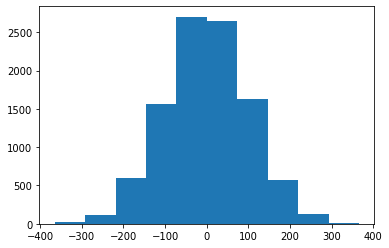

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

a = np.random.normal(0,100,size=(10000))
plt.hist(a)
plt.show()

И посмотрим, что будет с распределением значений этого вектора, если к нему применить softmax

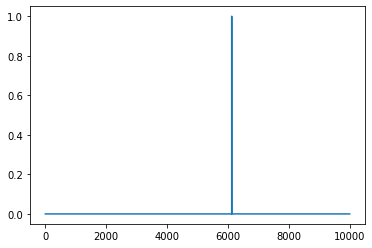

In [ ]:
from scipy.special import softmax

plt.plot(softmax(a))
plt.show()

Почти все значения 0 и одно (по случайным причинам), стало 1.
Мы получили так называемое вырожденное распределение - у него вся плотность сосредоточена в одной точке.

И получили на абсолютно случайных данных.

Это приведет к затуханию градиента - мы будем распространять ошибку только для 1 значения из 10000. Учиться сеть будет плохо

Но этого можно избежать - давайте просто отнормируем наши данные

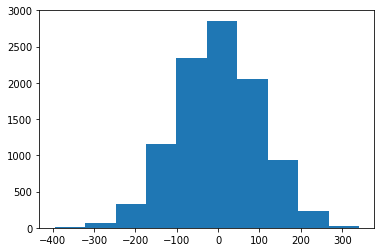

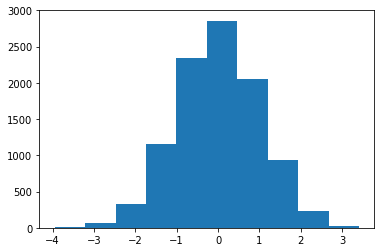

In [ ]:
std = np.random.normal(0,100,size=(10000))

unit_std = std/100

plt.hist(std)
plt.show()
plt.hist(unit_std)
plt.show()

По сути в распределении ничего не поменялось - только масштаб. Но теперь softmax работает нормально

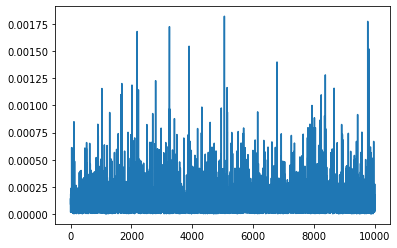

In [ ]:
plt.plot(softmax(unit_std))
plt.show()

Остается только понять, а как нормировать наши данные в нашем слое? Считать налету, наверное, не лучшая идея.

Наш слой делает сколярное произведение между двумя векторами, предположим, нормально распределенными

In [ ]:
c = []
for i in range(100):
	    a = np.random.normal(0,1,size=(100))
	    b = np.random.normal(0,1,size=(100))
	    c.append(np.dot(a,b))

In [ ]:
print(np.mean(c))

print(np.std(c))

1.1693784180095654
10.046559785669263


Видим, что среднее не сильно отличается от 0 (можно показать, что в среднем оно равно 0 для произведения нормально распределенных величин).

А вот стандартное отклонение растет. И, можно предположить, что растет оно как корень из размерности вектора. Так и есть. Потому и появляется именно такой нормировочный множитель в attention

### Keq, Query, Value на примере текста. Второй заход

Хорошо, у нас есть предложение, мы его разбили на токены, допустим, мы хорошо умеем кодировать эти токены.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/sentence_kqv.png" width="1000">

Но каждый токен закодирован на основе самого себя, и только, например, слово bank встречается в тексте два раза, и будет закодировано одинаково, хотя несет разные значения (берег и, собственно, банк).

Как нейросети их отличать? Ну, если мы попытаемся на основе только одного токена что-то сделать - никак.

А как улучшить кодирование каждого токена, чтобы два "банка" отличались?





Сделаем следующее - каждый токен подадим в нейросеть **и в качестве query**.

И будем аггрегировать полученную информацию, получая токен, который будет содержать более конкретную информацию

<img src ="https://miro.medium.com/max/1400/1*QeZiuWDYeTSMIDsQY-44zQ.jpeg" width="750">

Например, bank, который банк, будет содержать информацию о том, что он не просто bank, а "Bank of America", который нужно найти (find).

Такой подход - когда key, query и value формируются на основе одного и того же входа нейросети называется self-attention




## Self-Attention Layer

Сделаем это все в виде слоя

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/selfattention" width="700">

Что изменилось?

Теперь X участвует и в производстве K, и в производстве V, и в производстве Q. Потому и self-attention - предложение состоящее из слов X_i, ищет само себя в нашем дифференцируемом словаре. Почему это не приводит к тому, что мы просто получим вектор V?
Потому что значения X_i модифицируются и K != Q.







Еще один пример проблемы с текстом, который обычные методы решали плохо

Многие из нас знают Первый Закон Робототехники

**Second Law of Robotics**


A robot must obey the orders given it by human beings except where such orders would conflict with the First Law.

Представим, что машина хочет понять, что здесь написано. И ей нужно понять, что имеется ввиду под it.






Первым делом она формирует на основе каждого слова key и value.

<img src ="https://jalammar.github.io/images/gpt2/self-attention-example-folders-3.png" width="700">


Затем она смотрит, какие ключи похожи на Query, полученный из it

<img src ="https://jalammar.github.io/images/gpt2/self-attention-example-folders-scores-3.png" width="700">


Чтобы получить, что же на самом деле значит it, машина считает взвешенную сумму values, где  веса определяются похожестью query на value



<img src ="https://jalammar.github.io/images/gpt2/gpt2-value-vector-sum.png" width="700">



В итоге получается, что it представляет собой "a robot" (ну и само себя).

В чуть более векторном виде:

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/attention_example2.png" width="1000px">



Обновляем представление слова Anthony

<img src ="https://kodomo.fbb.msu.ru/FBB/year_21/attention_example3.png" width="800px">

## Positional encoding

Единственный возможный минус - наша нейросеть не учитывает порядка слов в предложении при составлении embedding. Это может нам мешать. Например, если в предложении два it, то они часто относятся к разным словам. Потому хотим ууметь учитывать информацию о позиции. Для этого к X при составлении Q добавляется информация о позиции.

Делается это хитрым образом - мы берем и добавляем к каждому значению исходного вектора токенов некую комбинацию sin и cos с разными параметрами.

Вектор PE, который мы будем добавлять к X будет определяться по следующей формуле

$$PE_{pos, 2i} = \sin {\dfrac {pos} {10000^{2i/d}}}$$

$$PE_{pos, 2i+1} = \cos {\dfrac {pos} {10000^{2i/d}}}$$

$pos$ - это позиция токена

$i$ - iя размерность токена

In [ ]:
import torch
import math
import torch.nn as nn
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].detach()
        return x

In [ ]:
pe = PositionalEncoding(20)
y = pe(torch.zeros(1, 100, 20)) # последовательность размера 100, каждый токен последовательности имеет размерность 20

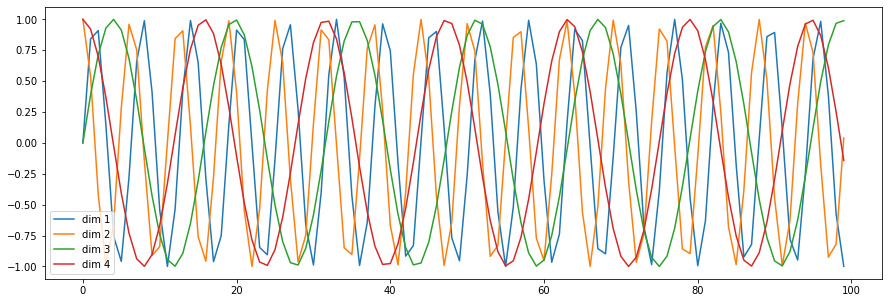

In [ ]:

plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 0:4].data.numpy())
plt.legend(["dim %d"%p for p in [1,2,3,4]])
plt.show()

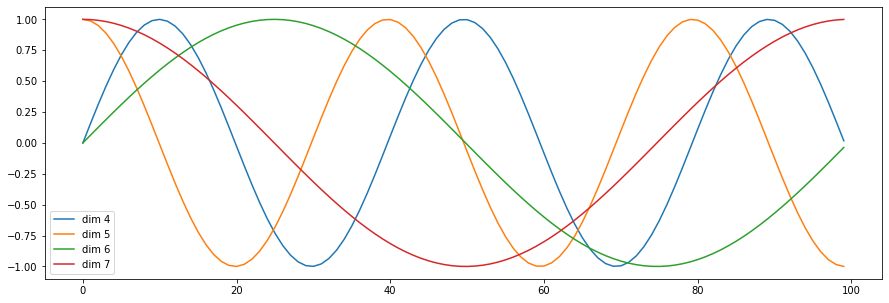

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])
plt.show()

Это помогает трснформеру достаточно уникальным образом определять каждую позицию и понимать относительное расстояние между разными токенами



## Multihead Self-Attention Layer

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/multihead_attention.png" width="700">



Давайте посмотрим на то, к каким словам предложения gave может иметь отношение. В общим случае глагол может иметь связку со многоми частями предложения. Как, например, к подлежащему, так и к причастиям.

В идеале, нам бы хотелось обратить внимние функции (attention) на все эти взаимосвязи. Для этого нам просто надо поставить несколько attention слоев парралельно. В идеале каждый будет учить что-нибудь свое - аналогия с конволюциями.

* Чтобы осуществить задуманное, вместо одного набора query, будем использовать несколько независимых наборов.

* Причем каждый набор будет считаться уникальной матрицей.

* Аналогично сделаем для keys и values. Количество таких наборов внутри keys, queries, values должно быть **одинаковым**.

* Обозначим это число как h - head, далее производим аналогичные манипуляции, при этом введем в параллель h таких функций attention
* На последнем шаге мы их соединяем (конкатинируем)

* При этом, можно заметить, что таком подходе на каждом шаге размерность токена будет увеличиваться (если, например, в качестве и key, и value, и query мы подаем одно и тоже предсталение токена). Если хотим сохранять управлять размерностью токена, то придется получать по меньшей мере value путем домножения на матрицу, размерность которой по второй оси меньше - **выполнять проекцию наших токенов в пространство меньшей размерности**

* В частности, можно подобрать размерность этого пространства таким образом, чтобы при конкатенации размерность полученного токена равнялась исходной.

<img src ="https://data-science-blog.com/wp-content/uploads/2022/01/mha_visualization-930x1030.png" width="400px">




## Attention is all you need

Оказывается, этот подход работает сам по себе. Не нужно добавлять никаких реккурентных слоев - просто делаем много правильно соединенных attention layers.
<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/attention_is_all.png" width="700">







## *Архитектура ванильного трансформера

### *Базовый блок

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/base_block" width="700">


Блок устроен следующим образом: входные вектора мы запускаем в блок self-attention и используем residual connection как обходной путь вокруг self-attention, затем мы их складываем. Так как обычно используют multi head self-attention, тут нам и пригождается возможность подобрать параметры так, чтобы размерности входных и выходных токенов не отличались.



После - применяем слой нормализации, затем - слой feed forward (MLP), плюс обходной путь вокруг feed forward.

<img src ="https://kodomo.fbb.msu.ru/FBB/year_20/ml/mlp_transformer.png" width="500">

Складываем выход MLP-части с residual connection и выполняем нормализацию.

Нормализация везде нужна для того, чтобы нейросеть нормально обучалась.

Заводим ли разный MLP на каждый токен (по позиции) - конечно нет. К каждому токену применяются MLP с одними и теми же весами.


В реальных моделях эти слои стекируют друг с другом и получается большая трансформер-модель.

<img src ="https://miro.medium.com/max/1400/1*63vv9pbICaRAIWF2me-efA.jpeg" width="700">


Это пример Encoder-модели. Такова рассматриваемая далее BERT. В такой модели на выходе мы получаем некое хорошее представление исходного предложения.

Но что если мы хотим сделать задачу перевода с одного языка на другой? Нужен еще Decoder



### *Decoder



#### *Первая стадия

На первой стадии то, как работает Decoder не так сильно отличается от работы Encoder.


<img src ="https://miro.medium.com/max/1400/1*R6_u8qGXKUyyGaHb9-mMDw.jpeg" width="700">

Тем не менее, есть один важный нюанс -  мы используем Masked Attention - наша нейросеть не должна видеть слов, которые еще не сгенерировала.

На основе первого этапа у нас формируются только query - наша нейросеть на основе того, что она уже сгенерировала решает, какая информация ей нужна дальше

#### *Вторая стадия

Теперь мы используем для K, V информацию, полученную из энкодера и получаем предсказание.

<img src ="https://miro.medium.com/max/2000/1*HKyS_RuocFun1LUubSf-jQ.jpeg" width="800">





### *Masked Self-Attention Layer




Если у нас стоит проблема, что мы не должны видеть часть слов в предложении - например, при генерации текста (по текущим словам предсказать следующее). Например, хотим сгенерировать фразу "robot must obey orders" на основе только первого слова.

Если мы скормим в трансформер во время обучения сразу все предложение, которое хотим генерировать, то у нас в первых словах будет "протекать" информация о предыдущих.
<img src ="https://jalammar.github.io/images/gpt2/queries-keys-attention-mask.png" width="700">









В этом случае мы можем просто на соответствующих местах матрицы E поставить минус бесконечности - тогда в ембедингах слов, которые не должны знать о каких-то словах, информации об этих словах не будет.

<img src ="https://jalammar.github.io/images/gpt2/transformer-attention-mask.png" width="700">



В результате мы сможем, после softmax "лишния" информация не будет использоваться при генерации ответа на query

<img src ="https://jalammar.github.io/images/gpt2/transformer-attention-masked-scores-softmax.png" width="700">


Благодаря этому трюку, у нас получается обучать transfomer по-прежнему как простую single-pass нейросеть, а не "скатываться" в RNN, где у нас возникнут проблемы с градиентами и временем работы



# Примеры применений Transformer

## Перевод текста

Непосредственное применение разобранной архитектуры Encoder-Decodee
<img src ="https://jalammar.github.io/images/xlnet/transformer-encoder-decoder.png" width="800">



## BERT

В случае BERT используется только Encoder часть

Это нейросеть, предобученная на огромном корпусе английского текста.

Она одновременно решала две задачи

В результате на вход подается все в таком виде:

<img src ="https://miro.medium.com/max/3200/1*D0_sVWpmOSaGCvm6gk9aHA.jpeg" width="700">

$CLS$ токен нужен для того, чтобы нейросети было, куда класть информацию обо всем предложении в целом.

$SEP$ нужен просто для того, чтобы разделять два предложения (если мы подаем их два) и для того, чтобы отмечать окончание. Использование $SEP$ с двумя целями позволяет подавать в уже обученную нейросеть только одно предложение.


Выход нейросети во время обучения выглядит таким образом:




### Masked Language Model

На вход дается предложение - в нем выбрано 15% токенов, из которых:
1. 80% замаскированы
2. 10% заменены случайным
3. 10% оставлены без изменений


Для первой задачи используем Encoder-Decoder

То есть у нас есть **Encoder**, который получает богатые представления и добавленный только на время обучения **Decoder** (не attention, просто MLP).

Именно Decoder отвечает за то, чтобы предсказывать пропущенные/замененные токены. Ошибка считается только по тем 15% токенов, для которых могло произойти изменения, а не по всему предложению.



Как гарантируется, что модель не заменяет имевшиеся в предложение слова на другие?



<img src ="https://miro.medium.com/max/1400/1*yTk92fAvqPDlabJJqkM4rw.png" width="700">


### Next Sentence Prediction

Для второй задачи - Classifier.

При этом на вход ему подается только сам CLS токен

<img src ="https://miro.medium.com/max/1400/1*UvFUs9afyoIGKj9F5qTIxw.png" width="700">

Обе задачи тренируем одновременно.


### Transfer learning с BERT

Нейросеть, обученную на таких задачах, можно было далее использовать при помощи transfer learning для решения целого спектра задач.

Обученную таким образом модель (оставляем только encoder), можно использовать для огромного числа других задач

<img src ="https://miro.medium.com/max/933/1*71lj0YoM5fkZB229XKAFrA.jpeg" width="700">



### Zero-shot learning

Более того, есть BERT, тренированная на большом числе разных языков.

Это позволяет, например, сравнивать предложения из разных языков, хотя мы этому даже не учились. Поиграть можно [здесь](https://colab.research.google.com/github/deepmipt/dp_tutorials/blob/master/Tutorial_2_DeepPavlov_BERT_transfer_learning.ipynb#scrollTo=S1iqGcxUINyU). Веса будут грузиться ДОЛГО

<img src ="https://github.com/deepmipt/dp_tutorials/blob/master/img/BERT_multilingual.png?raw=1" width="700">


### Специализированные аналоги BERT

Более того, можно тренировать BERT под строго определенные задачи - например, анализ текстов научных статей

<img src ="https://miro.medium.com/max/1500/0*svTduALJlF5JOD7x.png" width="800">




## GPT (Generative Pretrained Transformer )

В случае GPT используется только Decoder часть. Но теперь во всех частях используются masked attention



<img src ="https://jalammar.github.io/images/gpt2/gpt2-self-attention-qkv-1-2.png" width="800">

Это нейросеть обширно используется для, например, задачи генерации текста,













Работает она следующим образом - даем ей в качестве исходного входа какую-то затравку. Можно просто SOS-токен. Она дает какой-то выход. Подаем этот выход нейросети как вход.
Делаем так до тех пор, пока не надоест/не достигнем максимальной длины предложения/не встретим символ окончания генерации


<img src ="https://jalammar.github.io/images/xlnet/gpt-2-autoregression-2.gif" width="800">

Как ее обучали - на самом деле, тоже unsupervised. Но теперь перед моделью ставится задача предсказывать по предыдущим словам в предложении текущее.

Понятно, что такую модель можно сразу же идти и использовать для генерации.

Однако затем ее можно применять для многих других задач (опять же, путем transfer learning):


1. Классификации - подаем сразу все предложение, полученное представление используем для предсказания

2. Entailment (Определение логического следования) - даем изначальные данные, гипотезу, надо оценить, следует ли гипотеза из данных

3. Similarity - можем оценивать похожесть предложений. Так как это мы определяем порядок предложений, то чтобы не было произволо скормим будем использовать результат пропускания через нейросеть обоих возможных порядков.

4. Выбор варианта ответа на вопросы - может обучить нейросеть отвечать на вопросы с множественным выбором.

<img src ="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-27_at_12.41.44_PM.png" width="800">

Также можно научить нейросеть отвечать на вопросы и т.д.




Строго говоря, мы можем даже текст переводить с помощью GPT.

<img src ="https://jalammar.github.io/images/gpt2/decoder-only-transformer-translation.png" width="800">

Просто подаем предложение с токеном в конце, определяющим, на какой язык переводим







По аналогичной схеме можем научить нашу сеть делать summary текста

<img src ="https://jalammar.github.io/images/gpt2/decoder-only-summarization.png" width="800">


[Здесь](https://6b.eleuther.ai/) можно поиграться с open-source GPT-J

А [здесь](https://colab.research.google.com/github/kingoflolz/mesh-transformer-jax/blob/master/colab_demo.ipynb#scrollTo=e-NKauYvgTNG) - поиграться, но уже в Collab

# Self-supervised learning

Фактически одновременно с трансформерами получила ширкую известность идея self-supervised learning - на наборе неразмеченном датасете задать нейросети какую-то задачу.

<img src ="https://images.ctfassets.net/pzhspng2mvip/5n3LZLsXbPJ1cb272yZklY/6bd7d917bddf716f02f8219f1bb3bd36/fig_1.png" width="800">



И что дальше?

А дальше, если задача хорошая, то нейросеть, учась ее решать, поймет входные данные очень-очень хорошо и сформирует хорошее представление - эмбеддинг - наших данных.

А то, что это представление не оптивизирована под конкретную supervised-задачу, что могло бы привести к выкидыванию в общем-то важных признаков (вам не надо знать цвет животного, чтобы отличить собаку от кошки, но надо, если хотите отличать окраски и породы).

Предобученную таким образом модель можно адаптировать к бОльшему числу задач, причем, чаще эффективнее чем supervised-аналоги

Разумеется, чтобы все было хорошо, нужно придумать хорошую задачу. Нужно чтобы выполнялось правило - модель может решить эту задачу тогда, когда хорошо понимает данные

Например, можно все картинки в своем датасете разрезать на части и учить нейросеть собирать получившийся пазл.

<img src ="https://images.ctfassets.net/pzhspng2mvip/qd2cW4HaoVijHSmXp5bwY/d69296276fda1f5da0469a3207087797/fig_5.png" width="800">



И постойте, в случае BERT и GPT, по сути, мы это и делали!!!



Со временем развились другие подходы к данной задаче. Рассмотрим один из них, который стал наиболее популярным сейчас

## Contrastive learning

Откуда-то мы знаем, что такие-то объекты - похожи, а такие-то нет.

Мы ставим задачу, чтобы наша нейросеть давала похожим объеектам похожие эмбеддинги, а непохожим - непохожие.

Казалось бы - что проще. Но если мы не знаем разметки - откуда мы знаем какие объекты похожи, а какие - нет?



### SIMCLR

Давайте по-разному видоизменять (аугментировать) наши исходные изображения.

Тогда мы знаем, что изображения, полученные аугментацией одного и того же изображения - похожи.
Это факт.

Также мы можем допускать, что изображения, полуученные аугментацией разных изображений - отличаются.

Таким образом мы можем поставить перед нейронной сетью цель - пусть эмбеддинги аугментаций одного и того же изображения будут похожи, а разных - отличаться.

В этом и состоит подход SIMCLR (A Simple Framework for Contrastive Learning of Visual Representations)

<img src ="https://1.bp.blogspot.com/--vH4PKpE9Yo/Xo4a2BYervI/AAAAAAAAFpM/vaFDwPXOyAokAC8Xh852DzOgEs22NhbXwCLcBGAsYHQ/s640/image4.gif" width="800">


Подход работает, есть много предобученных им нейросетей, который можно использовать в своей работе


Примеры аугментаций

<img src ="https://1.bp.blogspot.com/-bO6c2IGpXDY/Xo4cR6ebFUI/AAAAAAAAFpo/CPVNlMP08hUfNPHQb2tKeHju4Y_UsNzegCLcBGAsYHQ/s640/image3.png" width="800">

Однако у подхода есть важное допущение - аугментации разных изображений действительно отличаются. А если у нас в датасете много дупликатов? Или собак одной породы и одного возраста?
Что делать тогда?

Кроме того, такой подход зависит от размера батча - сколько  аугментаций, которые должны отличаться - негативных объектов - мы сможем засунуть в один батч.

Проблема очень сложная и потому попытка самому использовать SIMCLR может занять достаточно много времени.

### BYOL

BYOL (Bootstrap Your Own Latent) - подход, который освобождает нас от необходимости использовать негативные объекты

<img src ="https://miro.medium.com/max/1400/1*PQFk0171DL8_FP3OkS0Plw.png" width="800">



Идея проста (точнее, так кажется на первый взгляд):

Пусть у нас будут нейросети "учитель" и "студент".

Каждой из них мы будем подавать аугментацию исходного изображения. Задача этих нейросетей - дать похожее представление для этих двух аугментаций

Где зарыта собака?

У нейросетей есть тривиальное решение - предсказывать всегда одно и то же представление. Кажется, мы никак от этого не защищены

И вот здесь уже начинается магия:

Учится градиентным спуском только студент. Веса же студента обновляются как экспоненциальное среднее весов учителя за время обучения.

Это, и тщательный подбор гиперпараметров, позволяют избежать схлопывания в тривиальное решение

### DINO

И нейросеть, которая была обучена таким образом СЕГМЕНТИРОВАТЬ изображения БЕЗ ОБУЧЕНИЯ С УЧИТЕЛЕМ - [DINO](https://ai.facebook.com/blog/dino-paws-computer-vision-with-self-supervised-transformers-and-10x-more-efficient-training/).

Подход - модификация BYOL. Теперь учителя и ученику даются еще и разные по природе аугментации.

Учитель видит только большие, захватывающие большую часть изображения, а студент - и большие, и маленькие.

При этом даже на маленькой части изображения он должен выдавать эмбединг похожий на эмбединг учителя на большой части.

Фактически - нейросеть учится по уху кота определять, что на картинке таки есть кот


<img src ="https://scontent-vie1-1.xx.fbcdn.net/v/t39.2365-6/10000000_208749027394474_3359566853088796337_n.gif?_nc_cat=105&ccb=1-5&_nc_sid=ad8a9d&_nc_ohc=cqht23uAUvgAX-Na4Su&_nc_ht=scontent-vie1-1.xx&oh=00_AT8IDZDRT4oJFqTGwy6a3KBH8_cIeCwCF_DQX3hpW9GBTA&oe=61BFD947" width="800">



Сегментацию мы увидим на семинаре.




Оказывается, эмбединги еще и хорошо отделяют разные объекты друг от друга

<img src ="https://scontent-vie1-1.xx.fbcdn.net/v/t39.2365-6/177871790_363624551852633_263144119734802610_n.gif?_nc_cat=105&ccb=1-5&_nc_sid=ad8a9d&_nc_ohc=fZLQTdSreZwAX-axVwh&_nc_ht=scontent-vie1-1.xx&oh=00_AT8kmwLOdSX83nxat_5V_E3E5cqPuRRhTlYBdts8Sq7MXA&oe=61BE56F6" width="800">


# Хорошие источники

[Про трансформеры](https://www.notion.so/Transformers-969f4b27c48147778c1e2dbda0c83ce0)

[Аннотированный трансформер](http://nlp.seas.harvard.edu/2018/04/03/attention.html)

[Код множества моделей с красивыами комментариями](https://nn.labml.ai/)

[BERT](https://medium.com/@samia.khalid/bert-explained-a-complete-guide-with-theory-and-tutorial-3ac9ebc8fa7c)

[Зоопарк BERT](https://ai.plainenglish.io/so-how-is-bert-different-ad43a42cab48)

[От NLP до Transformer](https://jonathan-hui.medium.com/nlp-bert-transformer-7f0ac397f524)

[Illustrated transformer](https://jalammar.github.io/illustrated-transformer/)

[Illustrated GPT-2](https://jalammar.github.io/illustrated-gpt2/)

[Open-source реализация GPT-3](https://arankomatsuzaki.wordpress.com/2021/06/04/gpt-j/)

[Transformer для русского языка](https://github.com/vlarine/transformers-ru)

[Еще про трансформеры](https://data-science-blog.com/blog/2021/04/07/multi-head-attention-mechanism/)